In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
os.environ["OMP_NUM_THREADS"] = "1"  # Set it to your desired number of threads
import missingno as msno

from IPython.display import display #To display dataframe with a nice format.

import plotly.graph_objs as go
import plotly.express as px
import plotly.graph_objects as go

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from yellowbrick.cluster import InterclusterDistance

from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.utils import check_random_state
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.metrics import adjusted_rand_score
from scipy.optimize import linear_sum_assignment


# Setting display precision for pandas
pd.set_option("display.precision", 2)
# Set display option to show all columns
pd.set_option('display.max_columns', None)

blue_green      = (82/255, 162/255, 160/255)
blue_green_dark = (41/255, 81/255, 81/255)

# ==================================================================================================
# Set the fontsize & Bold for each GRAPH !!!
# ==================================================================================================
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 14
plt.rcParams["axes.titleweight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["lines.linewidth"] = 3
plt.rcParams["lines.markersize"] = 10
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams['axes.titlepad'] = 20 

In [2]:
# ==================================================================================================
# READ DATA
# ==================================================================================================
import csv
url_df_data               = r"C:\Users\Olivi\OneDrive\Documents\OC_Formation_DATA_SCIENCE\PROJET5_segmentez_des_clients_dun_site_ecommerce\DATA\df_data_kmeans_without_cf.csv"
df_data_kmeans_without_cf = pd.read_csv(url_df_data)

print("Datasets loaded succesfully ! :D")

Datasets loaded succesfully ! :D


Segment 0: Start Recency = 684, End Recency = 694, Data Length = 191
Segment 1: Start Recency = 674, End Recency = 684, Data Length = 0
Segment 2: Start Recency = 664, End Recency = 674, Data Length = 0
Segment 3: Start Recency = 654, End Recency = 664, Data Length = 0
Segment 4: Start Recency = 644, End Recency = 654, Data Length = 0
Segment 5: Start Recency = 634, End Recency = 644, Data Length = 0
Segment 6: Start Recency = 624, End Recency = 634, Data Length = 0
Segment 7: Start Recency = 614, End Recency = 624, Data Length = 0
Segment 8: Start Recency = 604, End Recency = 614, Data Length = 0
Segment 9: Start Recency = 594, End Recency = 604, Data Length = 52
Segment 10: Start Recency = 584, End Recency = 594, Data Length = 161
Segment 11: Start Recency = 574, End Recency = 584, Data Length = 378
Segment 12: Start Recency = 564, End Recency = 574, Data Length = 567
Segment 13: Start Recency = 554, End Recency = 564, Data Length = 431
Segment 14: Start Recency = 544, End Recency = 

,Start Recency,End Recency,ARI,NB Customers
0,684,694,0.76,191
1,594,604,0.85,52
2,584,594,0.92,161
3,574,584,0.85,378
4,564,574,0.92,567
...,...,...,...,...
57,34,44,0.96,2145
58,24,34,0.94,2184
59,14,24,1.00,2437
60,4,14,0.84,1838


61    0.92
60    0.94
59    0.94
58    0.94
57    0.94
      ... 
4     0.86
3     0.85
2     0.84
1     0.81
0     0.76
Name: ARI, Length: 62, dtype: float64

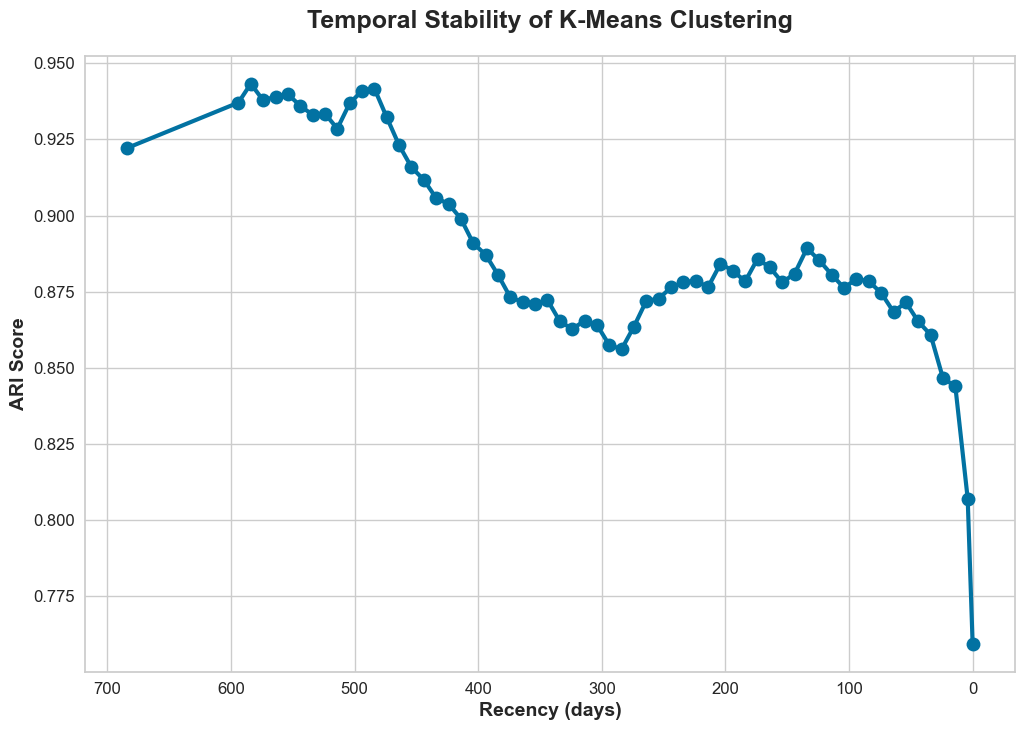

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



num_cluster = 4
segment_size = 10 # Define the size of each recency segment (e.g., 100 days)


data_init = df_data_kmeans_without_cf # Define data_init
total_recency_days = data_init['recency'].max() # Calculate the total duration of recency
num_segments = int(np.ceil(total_recency_days / segment_size)) # Calculate the number of segments

# ==================================================================================================
# COMPUTE KMEANS ON THE FULL DATASET (CLUSTER1)
# ==================================================================================================
# Perform K-means clustering for all values of recency (CLUSTER1)
kmeans_all = Pipeline([
    ("preprocessor", None),
    ("kmeans", KMeans(n_clusters=num_cluster, n_init=10, random_state=42))
])  
kmeans_all.fit(data_init)
cluster_labels_all = kmeans_all.named_steps['kmeans'].labels_


# ==================================================================================================
# COMPUTE KMEANS FOR EACH TIME SEGMENT (CLUSTER2)
# COMPUTE ARI BETWEEN CLUSTER1 and CLUSTER2 for the desired time segments
# ==================================================================================================
ari_scores = []
# Iterate over the segments
for i in range(num_segments):
    # Define the start recency for the segment
    start_recency = max(total_recency_days - (i + 1) * segment_size, 0)
    end_recency = total_recency_days - i * segment_size

    
    # Filter data for the current segment
    data_segment = data_init[(data_init['recency'] >= start_recency) & (data_init['recency'] < end_recency)]
    
    print(f"Segment {i}: Start Recency = {start_recency}, End Recency = {end_recency}, Data Length = {len(data_segment)}")

    # Check if the segment contains any data
    if len(data_segment) == 0:
        continue
    
    # Perform K-means clustering for the segment (CLUSTER2)
    kmeans_segment = Pipeline([
        ("preprocessor", None),
        ("kmeans", KMeans(n_clusters=num_cluster, n_init=10, random_state=42))
    ])  
    kmeans_segment.fit(data_segment)
    cluster_labels_segment = kmeans_segment.named_steps['kmeans'].labels_
    
    # Compare CLUSTER1 and CLUSTER2 for the same days used in the segment and compute ARI
    aligned_indices = data_init[(data_init['recency'] >= start_recency) & (data_init['recency'] < end_recency)].index
    cluster_labels_aligned = cluster_labels_all[aligned_indices]
    ari = adjusted_rand_score(cluster_labels_aligned, cluster_labels_segment)
    ari_scores.append([start_recency, end_recency, ari,  len(data_segment)])

# Convert the ARI scores to a DataFrame
ari_scores_df = pd.DataFrame(ari_scores, columns=["Start Recency", "End Recency", "ARI", "NB Customers"])
display(ari_scores_df)
# ==================================================================================================
# PLOT SMOOTH ARI
# ==================================================================================================
# Define the window size for the rolling mean
window_size = 20

# Smooth the ARI scores using a rolling mean
smoothed_ari_scores = ari_scores_df["ARI"].rolling(window=window_size, min_periods=1).mean()
smoothed_ari_scores = smoothed_ari_scores[::-1]

display(smoothed_ari_scores)

# Plot ARI Score with smoothed variation
plt.figure(figsize=(12,8))
plt.plot(ari_scores_df["Start Recency"], smoothed_ari_scores, marker='o', linestyle='-')  # Plot smoothed ARI against start recency
plt.xlabel("Recency (days)")
plt.ylabel("ARI Score")
plt.title("Temporal Stability of K-Means Clustering")
plt.gca().invert_xaxis()  # Reverse the x-axis
plt.show()


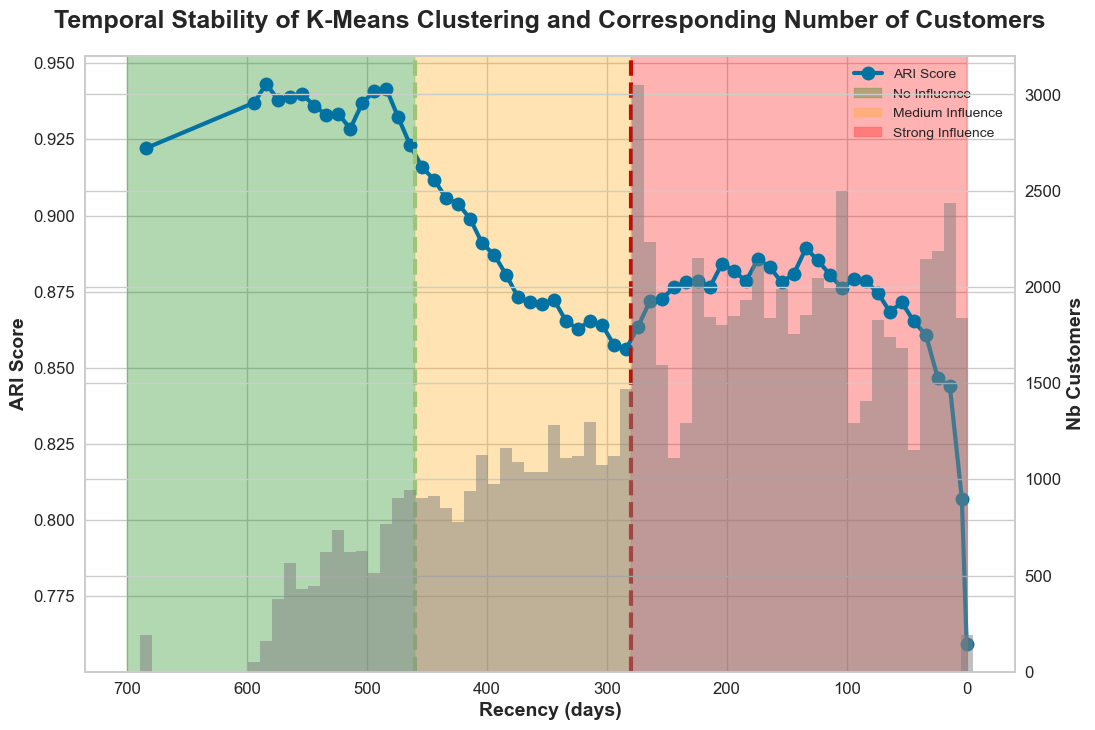

In [4]:
# ==================================================================================================
# PLOT SMOOTH ARI WITH INFLUENCE REGIONS AND HISTOGRAM of NB Customers by TIME SEGMENT
# ==================================================================================================
# Plot ARI Score with smoothed variation
plt.figure(figsize=(12,8))

# Plot smoothed ARI against start recency
plt.plot(ari_scores_df["Start Recency"], smoothed_ari_scores, marker='o', linestyle='-', label='ARI Score')

# Draw vertical lines
plt.axvline(x=460, color='g', linestyle='--')
plt.axvline(x=280, color='r', linestyle='--')

# Color regions
plt.axvspan(700, 460, color='green', alpha=0.3, label='No Influence')
plt.axvspan(460, 280, color='orange', alpha=0.3, label='Medium Influence')
plt.axvspan(280, 0, color='red', alpha=0.3, label='Strong Influence')

plt.xlabel("Recency (days)")
plt.ylabel("ARI Score")
plt.title("Temporal Stability of K-Means Clustering and Corresponding Number of Customers")

# Move legend to top right
plt.legend(loc='upper right')

plt.gca().invert_xaxis()  # Reverse the x-axis

# Create a 2nd graph under this one on the same figure
ax2 = plt.gca().twinx()

# Plot histogram of NB Customers
ax2.bar(ari_scores_df["Start Recency"], ari_scores_df["NB Customers"], width=10, color='gray', alpha=0.5)
ax2.set_ylabel("Nb Customers")

plt.show()


In [5]:
# # ==================================================================================================
# # CALCULATE DESCRIPTIVE STATISTICS OVER TIME
# # ==================================================================================================
# # Define the number of cluster and segment size
# num_cluster = 4
# segment_size = 10  # Define the size of each recency segment (e.g., 100 days)

# # Assuming df_data_kmeans_without_cf contains your data
# # Let's assume 'recency' is a timestamp indicating the time of observation

# # Step 1: Divide your data into appropriate time periods
# # For example, let's divide the data into segments similar to the previous code
# total_recency_days = df_data_kmeans_without_cf['recency'].max()
# num_segments = int(np.ceil(total_recency_days / segment_size))

# # Define the start and end recency for each segment
# start_recency_segments = [max(total_recency_days - (i + 1) * segment_size, 0) for i in range(num_segments)]
# end_recency_segments = [total_recency_days - i * segment_size for i in range(num_segments)]

# # Convert recency segments into corresponding time periods
# time_periods = [f'Segment {i+1}: {start} - {end}' for i, (start, end) in enumerate(zip(start_recency_segments, end_recency_segments))]

# # Step 2: Calculate descriptive statistics for numerical features over time
# stats_by_time = df_data_kmeans_without_cf.groupby('recency').agg(['mean', 'std'])

# # Step 3: Plot the evolution of descriptive statistics over time
# plt.figure(figsize=(12, 8))

# # Plot the evolution of means over time
# plt.subplot(2, 1, 1)
# for column in stats_by_time.columns.levels[0]:
#     plt.plot(stats_by_time.index, stats_by_time[column]['mean'], label=f'Mean {column}')
# plt.xlabel('Recency (days)')
# plt.ylabel('Mean Value')
# plt.title('Evolution of Mean Over Time')
# plt.legend()
# plt.gca().invert_xaxis()  # Reverse the x-axis

# # Plot the evolution of standard deviations over time
# plt.subplot(2, 1, 2)
# for column in stats_by_time.columns.levels[0]:
#     plt.plot(stats_by_time.index, stats_by_time[column]['std'], label=f'Std {column}')
# plt.xlabel('Recency (days)')
# plt.ylabel('Standard Deviation Value')
# plt.title('Evolution of Standard Deviation Over Time')
# plt.legend()
# plt.gca().invert_xaxis()  # Reverse the x-axis

# plt.tight_layout()  # Adjust layout to prevent overlapping
# plt.show()


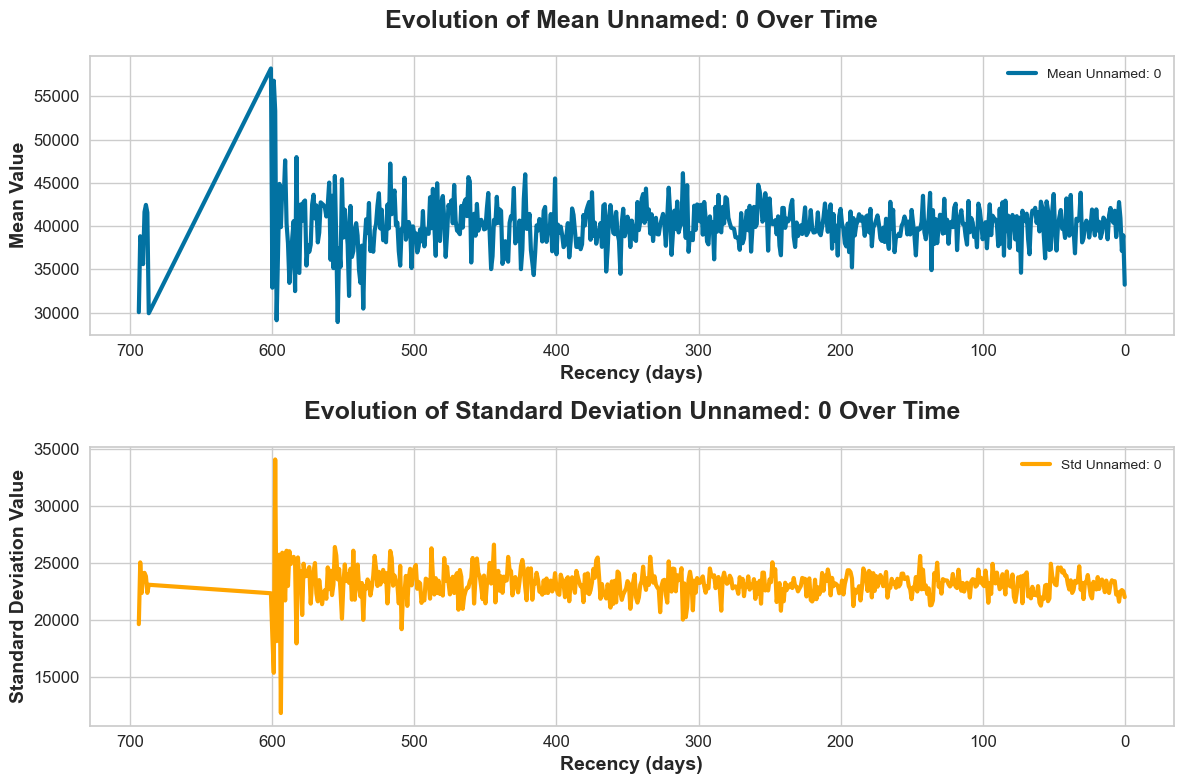

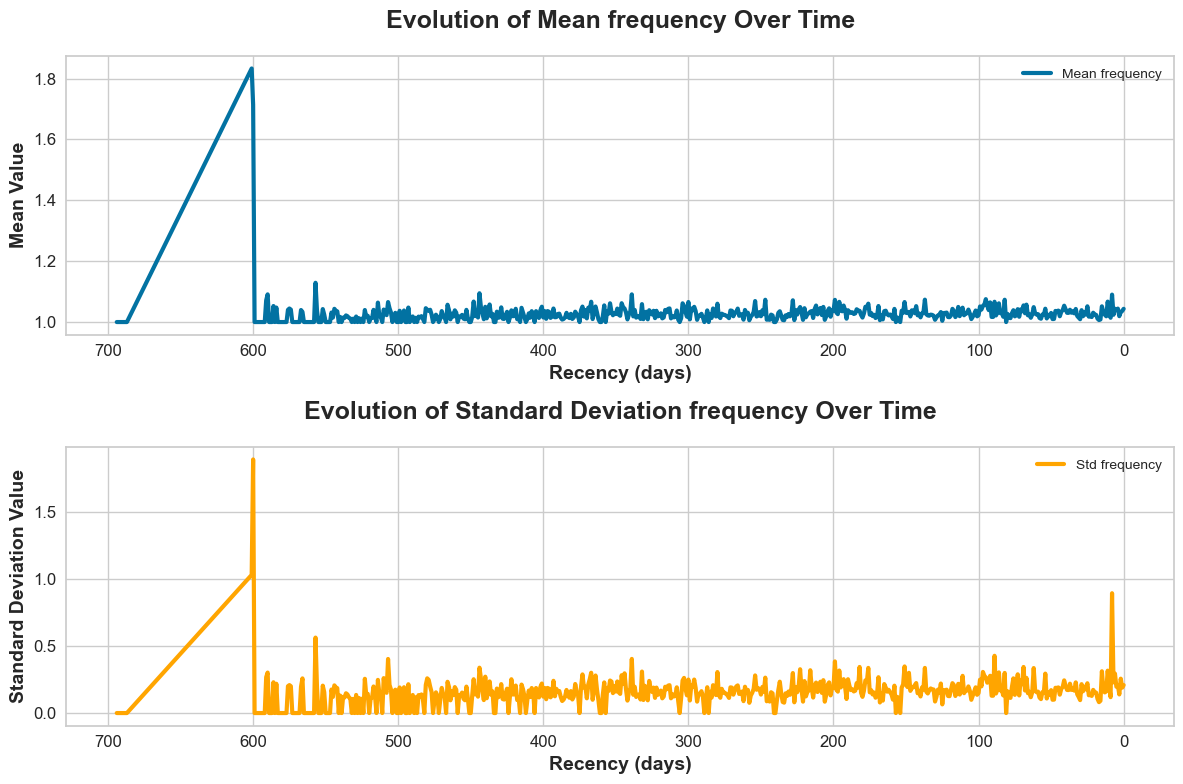

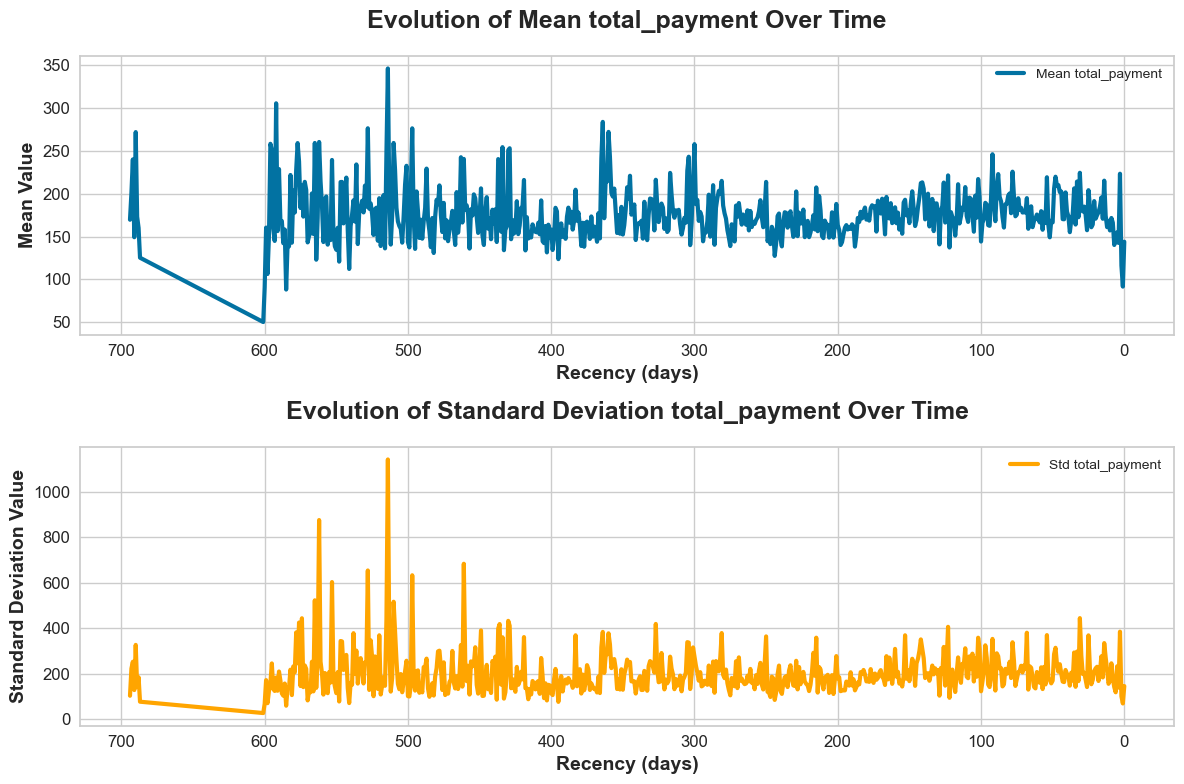

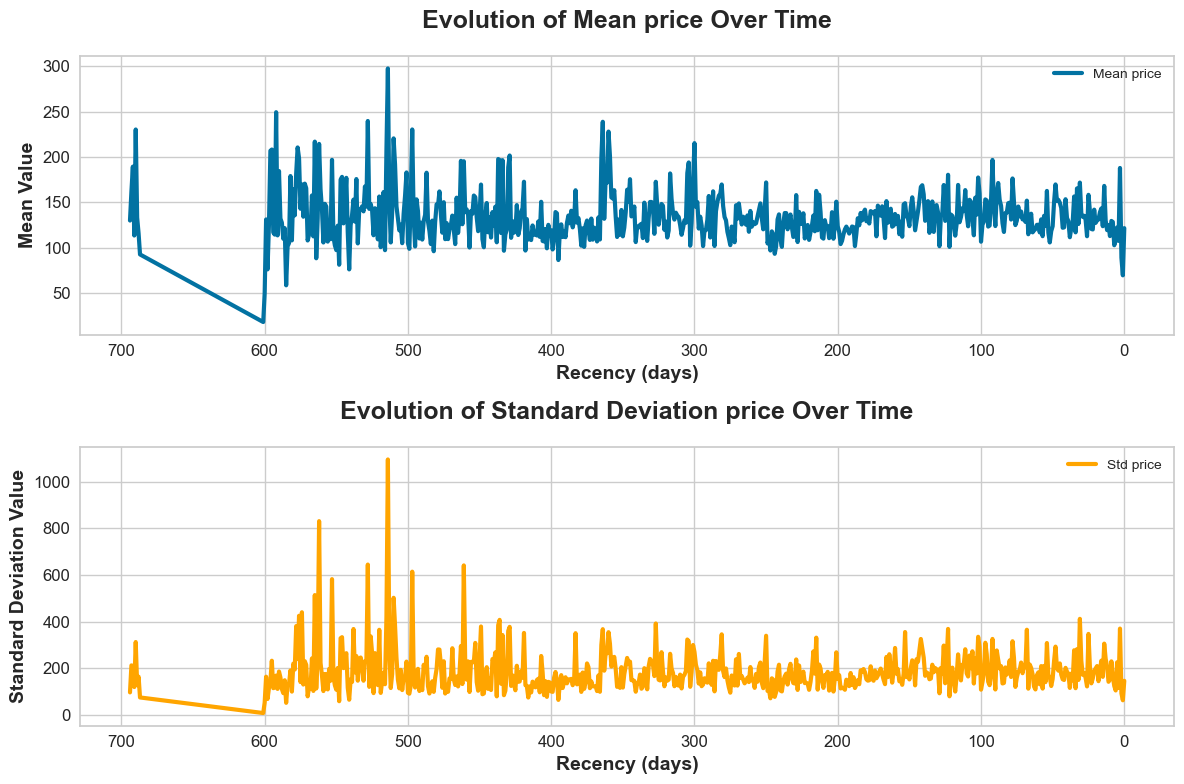

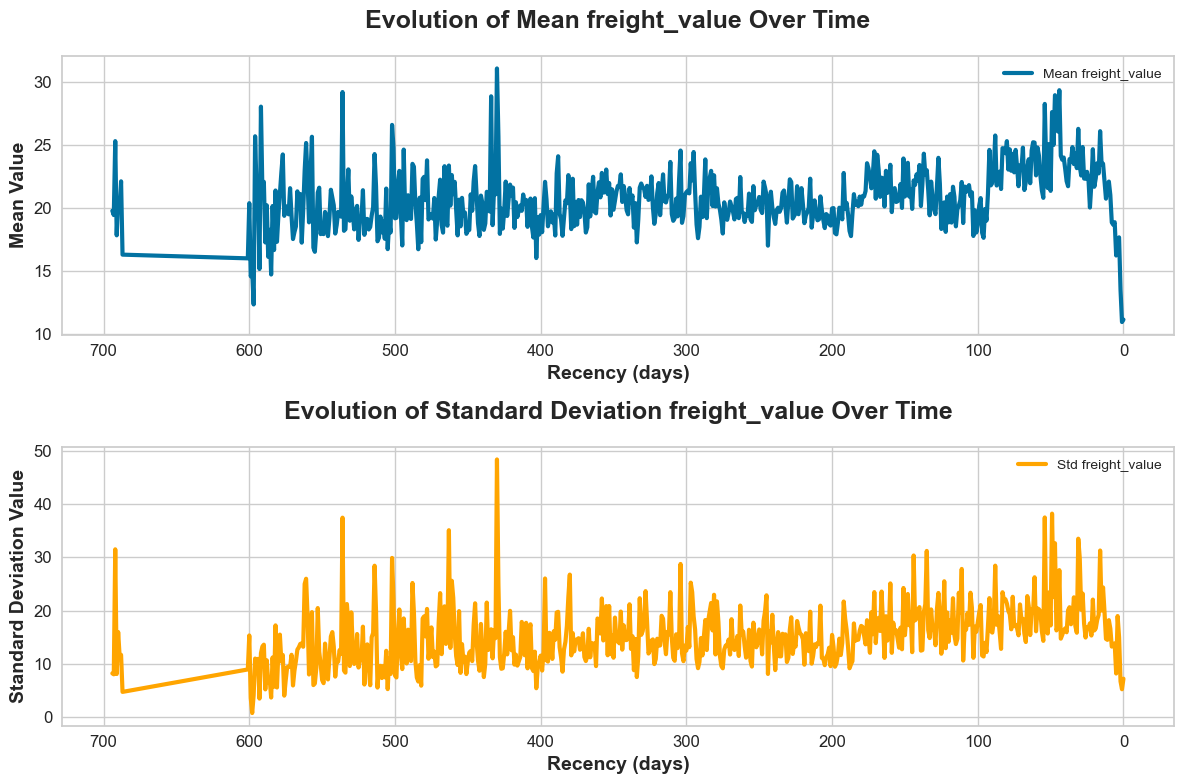

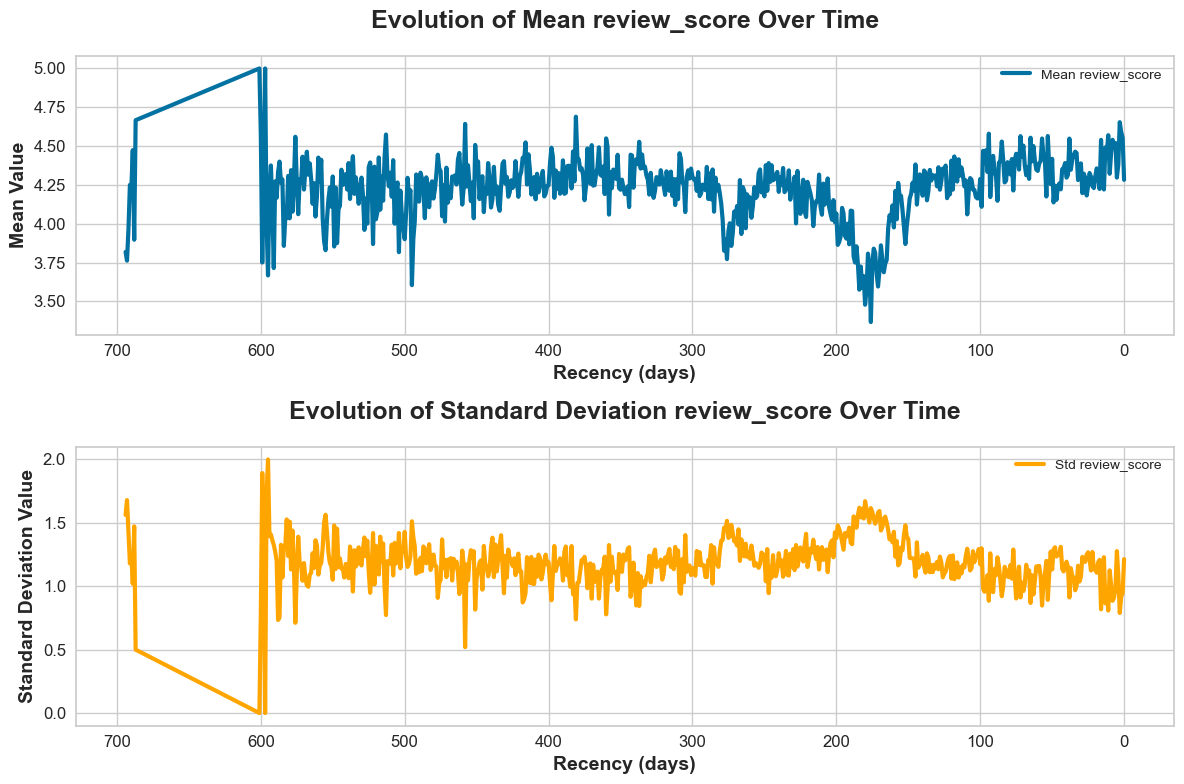

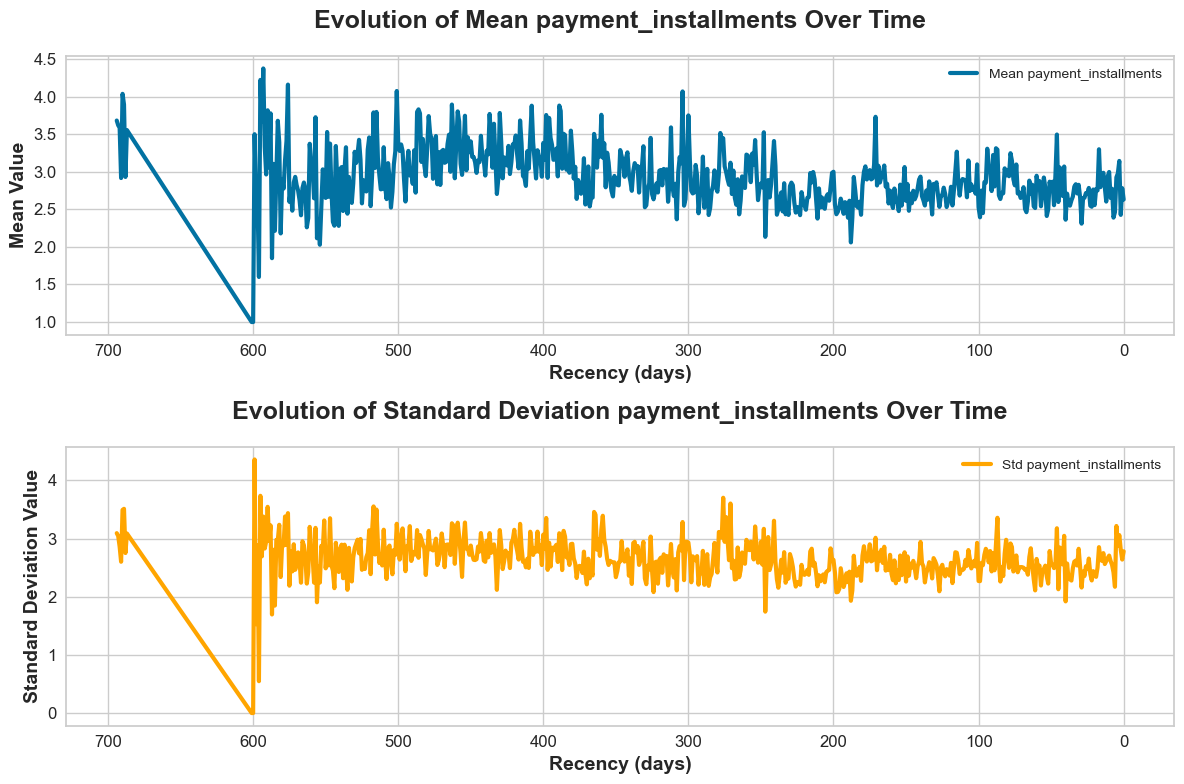

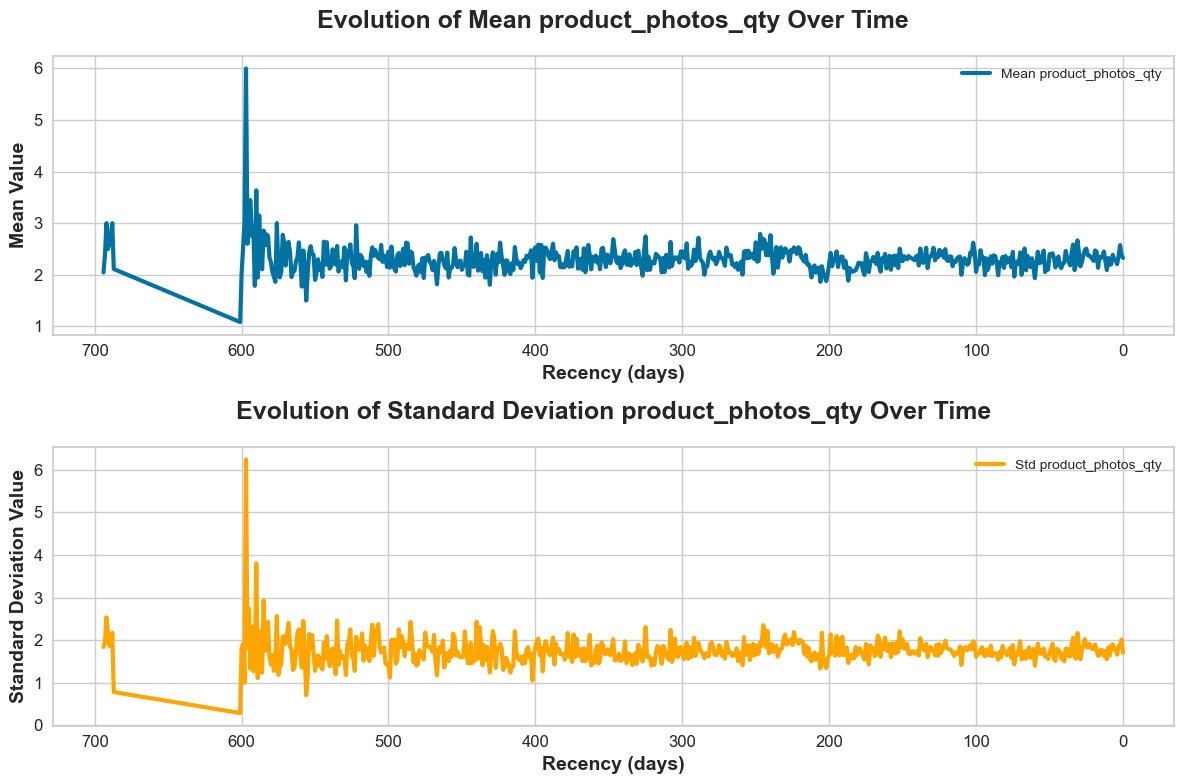

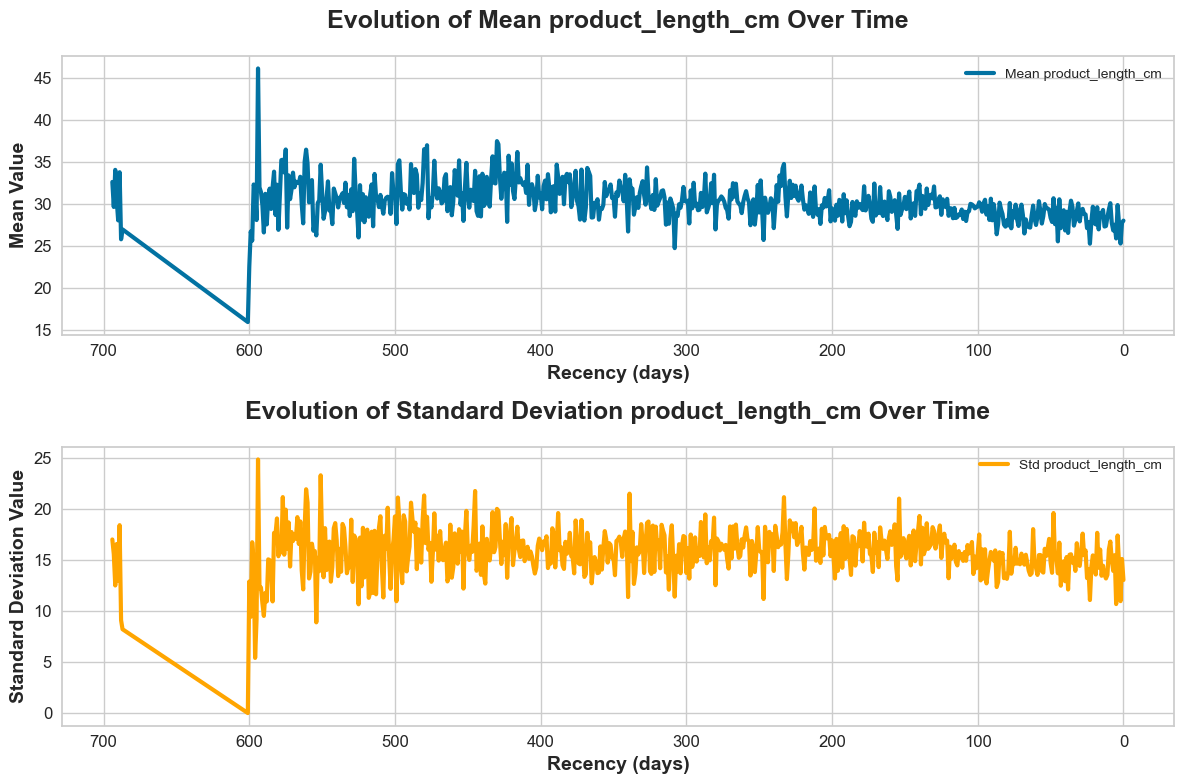

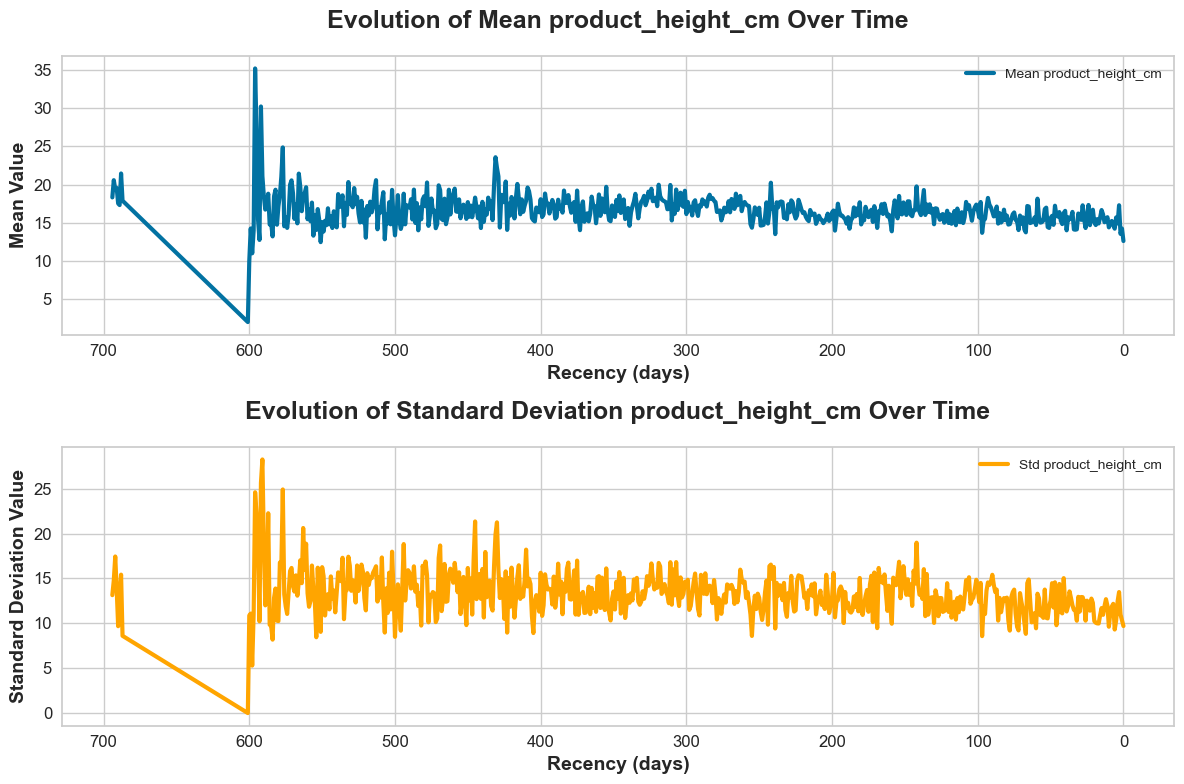

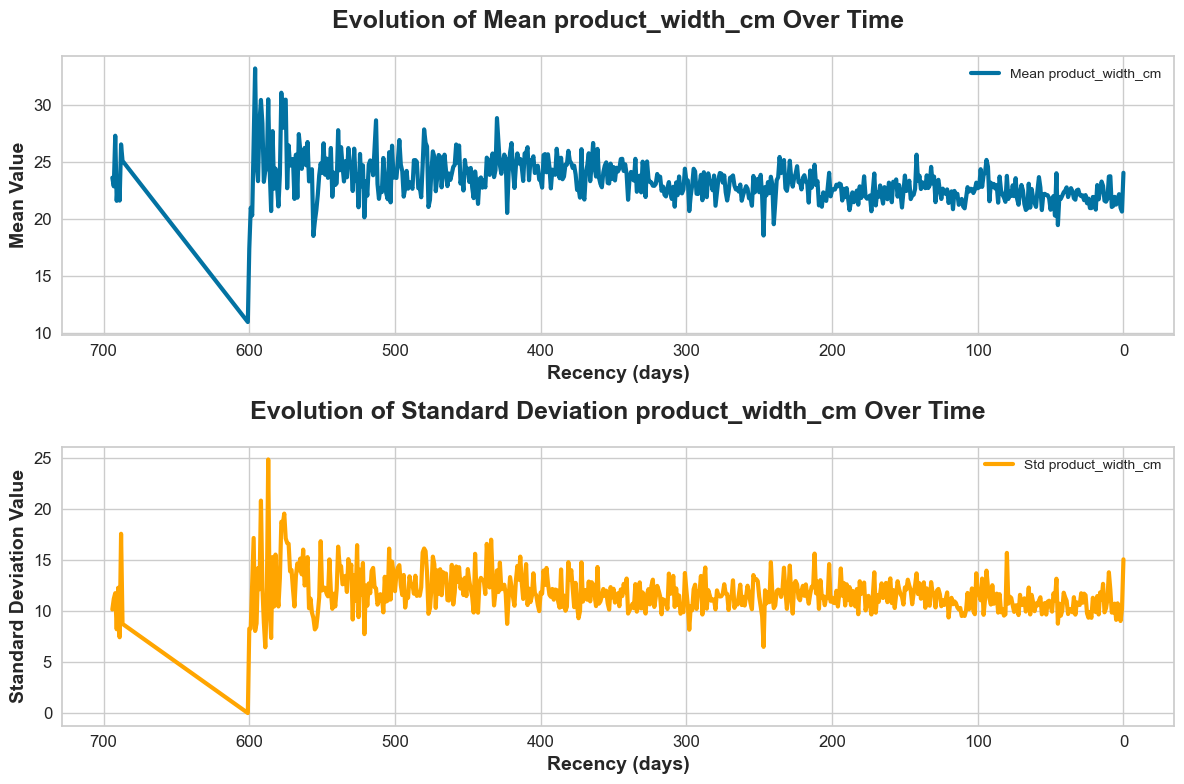

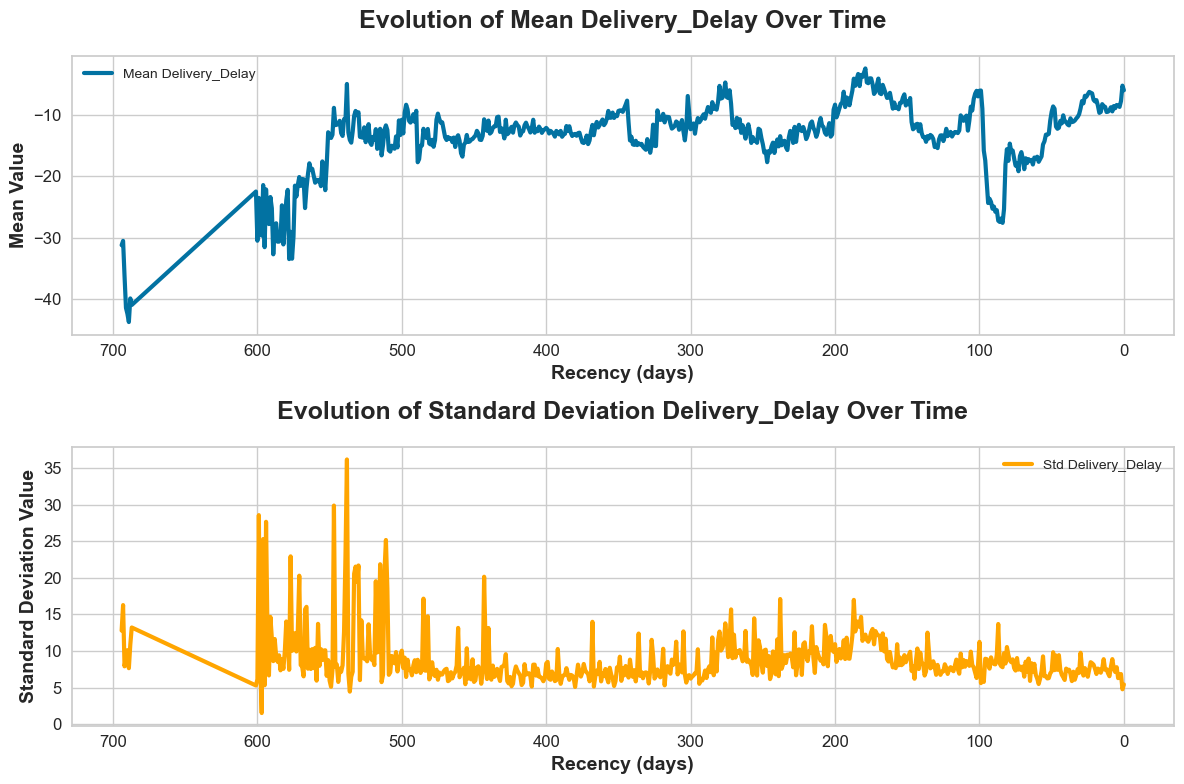

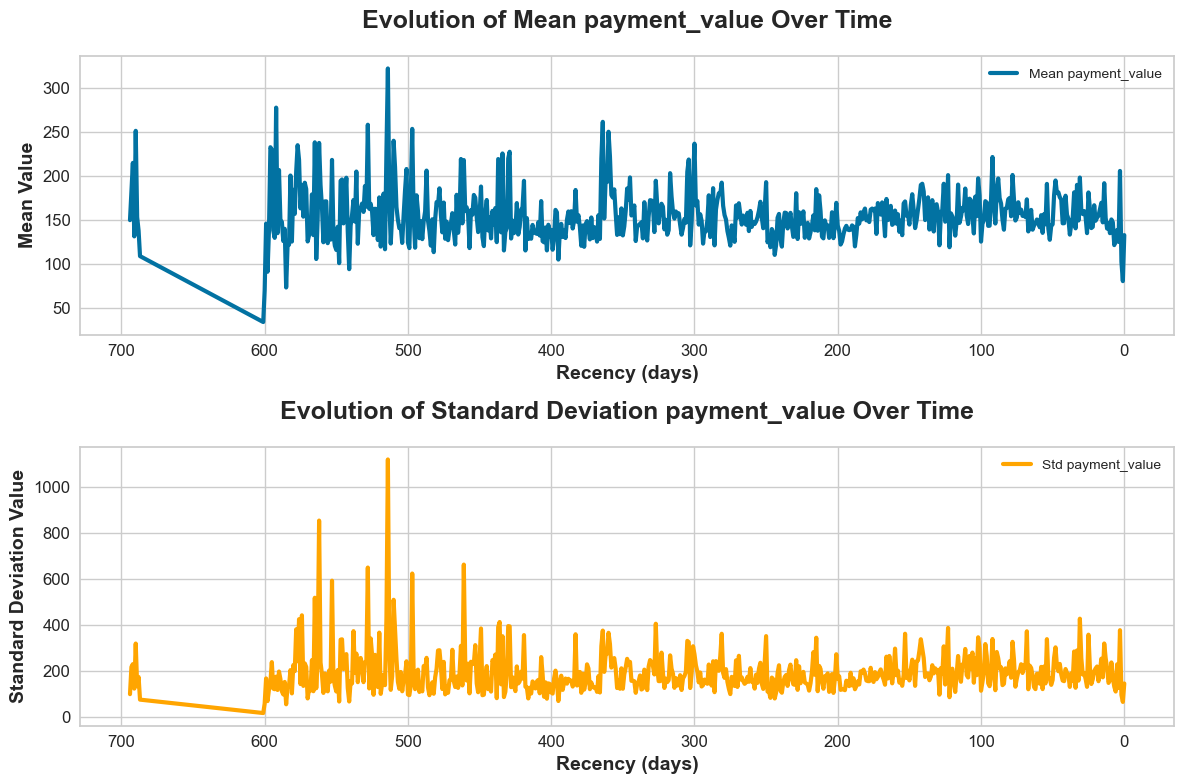

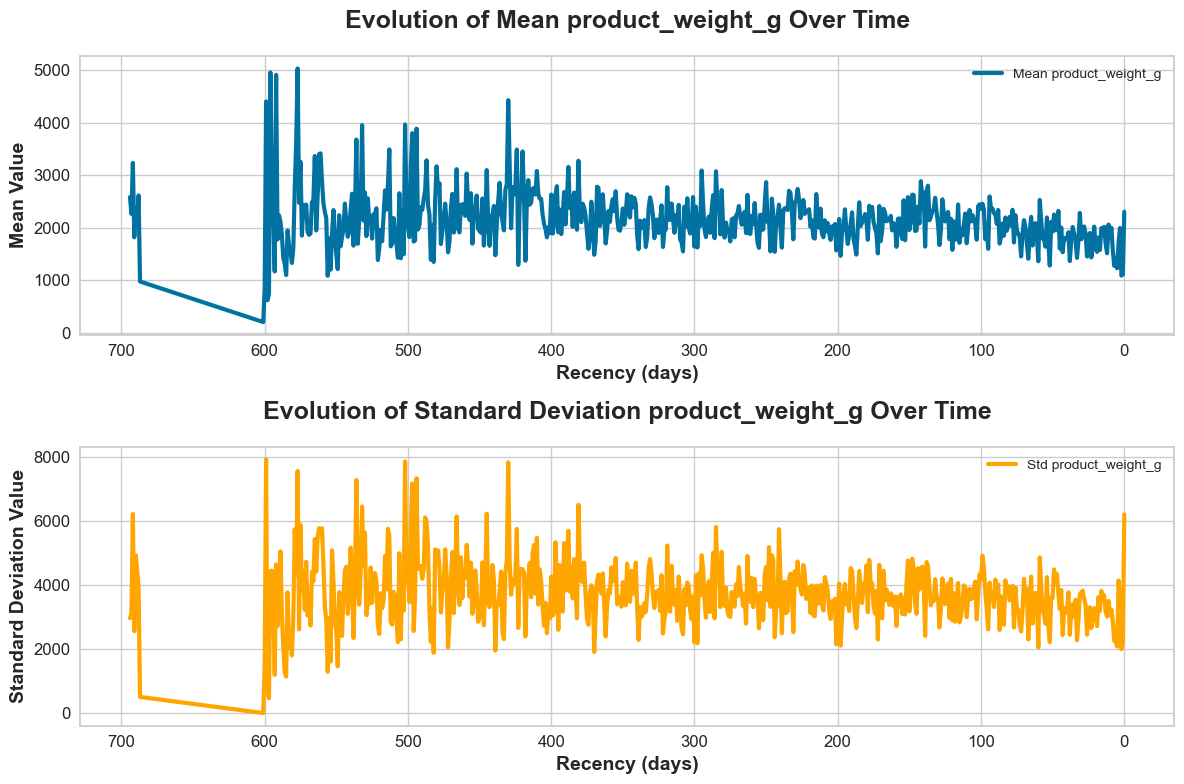

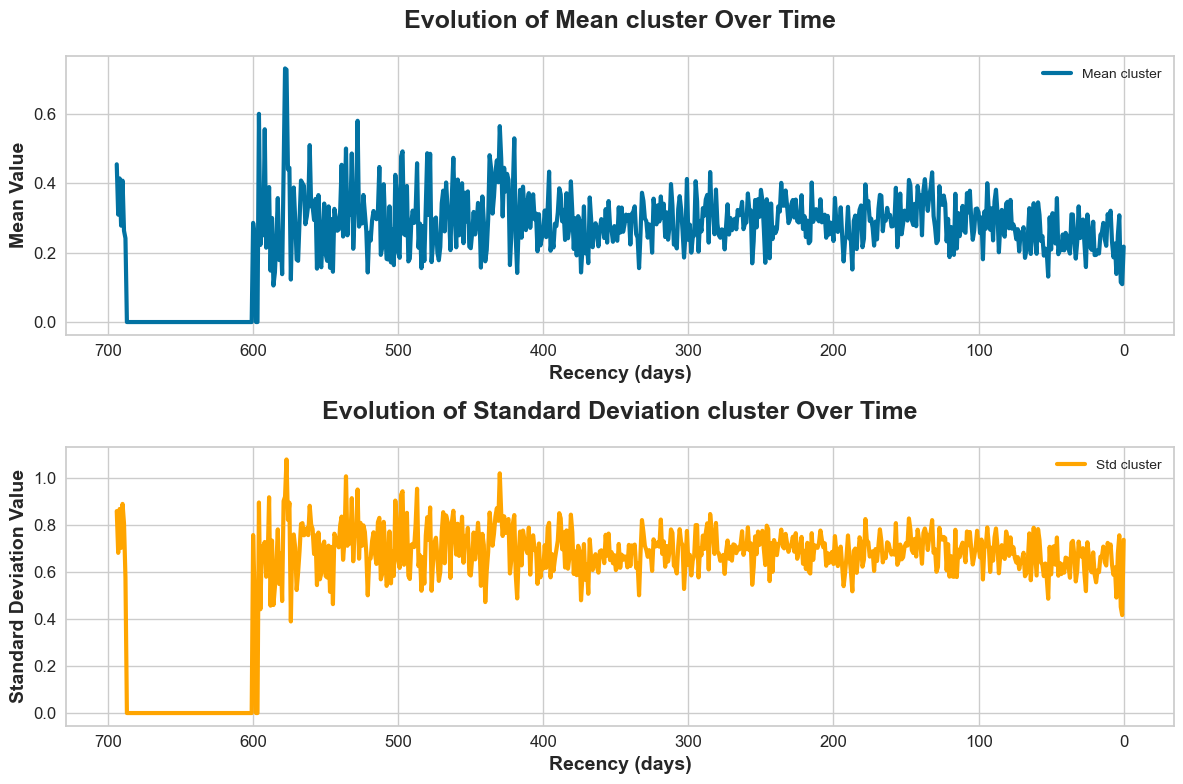

In [6]:
# ==================================================================================================
# CALCULATE DESCRIPTIVE STATISTICS OVER TIME
# ==================================================================================================
# Define the number of cluster and segment size
num_cluster = 4
segment_size = 10  # Define the size of each recency segment (e.g., 100 days)

# Assuming df_data_kmeans_without_cf contains your data
# Let's assume 'recency' is a timestamp indicating the time of observation

# Step 1: Divide your data into appropriate time periods
# For example, let's divide the data into segments similar to the previous code
total_recency_days = df_data_kmeans_without_cf['recency'].max()
num_segments = int(np.ceil(total_recency_days / segment_size))

# Define the start and end recency for each segment
start_recency_segments = [max(total_recency_days - (i + 1) * segment_size, 0) for i in range(num_segments)]
end_recency_segments = [total_recency_days - i * segment_size for i in range(num_segments)]

# Convert recency segments into corresponding time periods
time_periods = [f'Segment {i+1}: {start} - {end}' for i, (start, end) in enumerate(zip(start_recency_segments, end_recency_segments))]

# Step 2: Calculate descriptive statistics for numerical features over time
stats_by_time = df_data_kmeans_without_cf.groupby('recency').agg(['mean', 'std'])

# Step 3: Plot the evolution of descriptive statistics over time
for column in stats_by_time.columns.levels[0]:
    plt.figure(figsize=(12, 8))

    # Plot the evolution of means over time for the current feature
    plt.subplot(2, 1, 1)
    plt.plot(stats_by_time.index, stats_by_time[column]['mean'], label=f'Mean {column}')
    plt.xlabel('Recency (days)')
    plt.ylabel('Mean Value')
    plt.title(f'Evolution of Mean {column} Over Time')
    plt.legend()
    plt.gca().invert_xaxis()  # Reverse the x-axis

    # Plot the evolution of standard deviations over time for the current feature
    plt.subplot(2, 1, 2)
    plt.plot(stats_by_time.index, stats_by_time[column]['std'], label=f'Std {column}', color='orange')
    plt.xlabel('Recency (days)')
    plt.ylabel('Standard Deviation Value')
    plt.title(f'Evolution of Standard Deviation {column} Over Time')
    plt.legend()
    plt.gca().invert_xaxis()  # Reverse the x-axis

    plt.tight_layout()  # Adjust layout to prevent overlapping
    plt.show()
